In [104]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from core.analysis import access_db, get_senses, fb_to_local, annotate_mtx
from core import semcor_bert_pipeline
from core.metrics import *

## Binary Logistic Regression

For the shared words, we find that homonymous and polysemous senses are able to be distinguished

In [2]:
shared_metrics = {}
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']
fmt_sense_12 = lambda w: [w + '.01', w + '.02']
shared_senses = [fmt_sense_12(w) for w in shared_words]
shared_senses[-1] = ['degree.n.01', 'academic_degree.n.01']
shared_senses[1] = ['airplane.n.01', 'plane.n.02']
for w_s in zip(shared_words, shared_senses):
    model_data = binary_logistic(w_s[0], w_s[1])
    weight_values, weight_indices = nonzero_weights(model_data['model'])
    f_scores, accuracies, wrong_indices = k_fold_cv(model_data['data'], model_data['transformed_labels'], k = )
    shared_metrics[w_s[0]] = {'senses': w_s[1], 'data': model_data, 'weights': weight_values,
                    'weight_indices': weight_indices, 'f1_kfold': f_scores, 'acc_kfold': accuracies,
                             'incorrect_indices': wrong_indices}
    

/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [3]:
shared_stats = []
incorrect = []
for k in shared_metrics:
    word_results = shared_metrics[k]
    weights = word_results['weights']
    incorrect.append(misclassified_sentences(word_results['data'], word_results['incorrect_indices']))
    shared_stats.append({'word_type': k, 'avg_f1': np.mean(word_results['f1_kfold']), 'avg_acc': np.mean(word_results['acc_kfold']),
    'pct_nonzero_weights': len(weights) / 768, 'max_wt': max(weights), 'min_wt': min(weights), 'mean_nonzero_wt': np.mean(weights), 'sd_nonzero_wt': np.std(weights)})
pd.DataFrame(shared_stats)

,word_type,avg_f1,avg_acc,pct_nonzero_weights,max_wt,min_wt,mean_nonzero_wt,sd_nonzero_wt
0,foot.n,1.000000,1.000000,0.031250,0.221638,-0.229722,0.028953,0.132456
1,plane.n,0.933333,0.980000,0.015625,0.491381,-0.265000,0.054483,0.223284
2,model.n,0.518095,0.885455,0.037760,0.274155,-0.291541,0.020775,0.136917
3,table.n,0.992000,0.993548,0.033854,0.475794,-0.253788,0.013552,0.151044
4,degree.n,1.000000,1.000000,0.018229,0.456742,-0.227727,0.001208,0.166292


Misclassified senses (Only binary classification, 3/16 senses for math plane were misclassified)

In [4]:
pd.set_option('display.max_colwidth', 500)
pd.concat(incorrect)

,true_label,sentences
0,plane.n.02,The plane of the action in the scene is not parallel with the plane of the film in the camera or on the screen .
0,model.n.01,His first model arrived at dusk .
1,model.n.01,"We devote a chapter to the binomial distribution not only because it is a mathematical model for an enormous variety of real life phenomena , but also because it has important properties that recur in many other probability models ."
2,model.n.01,His first model arrived at dusk .
3,model.n.01,His first model arrived at dusk .
4,model.n.01,The model quite plainly thought Michelangelo crazy ; only the instructions from his rabbi kept him from bolting .
5,model.n.01,"But at the end of the sitting , when Michelangelo showed him the quick , free drawings , with the mother roughed in , holding her son , the model grasped what Michelangelo was after , and promised to speak to his friends ."
0,table.n.01,The registration figures given in Table 2 must be interpreted with caution since the estimate for eligible electors were made without the benefit of a reliable census .


I thought this might be useful to see if weights at similar positions were used.

In [7]:
[(k, shared_metrics[k]['weight_indices']) for k in shared_words]

[('foot.n',
  array([ 13,  29,  40,  70,  89, 184, 191, 217, 231, 278, 287, 304, 308,
         332, 493, 518, 528, 532, 547, 637, 664, 693, 709, 730])),
 ('plane.n',
  array([105, 157, 254, 286, 308, 324, 411, 413, 448, 513, 539, 619])),
 ('model.n',
  array([ 18,  49,  68,  74,  79, 101, 114, 242, 254, 259, 282, 289, 340,
         364, 450, 473, 477, 509, 520, 523, 525, 527, 552, 574, 586, 597,
         618, 739, 749])),
 ('table.n',
  array([ 37,  67,  94, 136, 143, 188, 213, 228, 252, 286, 298, 317, 332,
         334, 363, 376, 393, 445, 481, 487, 552, 661, 666, 680, 705, 753])),
 ('degree.n',
  array([ 15,  22, 220, 262, 328, 350, 432, 523, 537, 541, 544, 620, 622,
         724]))]

## All Classes

In [125]:
def k_fold_cv(x, y, k = 5, labels = []):
    kf = KFold(n_splits = k, shuffle = True)
    f = []
    acc = []
    incorrect_indices = []
    confusion_matrices = []
    for train_index, test_index in kf.split(x):
        model = LogisticRegression(penalty = 'l1', multi_class = 'multinomial', solver = 'saga', max_iter = 5000)
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        test_pred = model.predict(X_test)
        #print(classification_report(y_test, test_pred))
        f.append(f1_score(y_test, test_pred, average = "weighted"))
        acc.append(accuracy_score(y_test, test_pred))
        confusion_matrices.append(confusion_matrix(y_test, test_pred, labels = np.unique(y)))
        incorrect_indices +=[i[0] for i in np.argwhere(y_test != test_pred) if i[0] not in incorrect_indices]
    return f, acc, incorrect_indices, confusion_matrices


In [126]:
def logistic_cv(lemma, sel_senses = [], use_masc = True):
    name, pos = lemma.split(".")
    data = semcor_bert_pipeline.load_data(name, pos, 'semcor')
    embeddings = data['embeddings']
    sense_labels = np.asarray(data['sense_labels'])
    strip_synset = lambda s: s.strip("Synset()").strip("'")
    target_senses = [strip_synset(i) for i in data['sense_names']]
    sentences = np.asarray(data['original_sentences'])
    try:
        masc_data = semcor_bert_pipeline.load_data(name, pos, 'masc')
        embeddings += masc_data['embeddings']
        sense_labels += masc_data['sense_labels']
    except:
        pass
    le = LabelEncoder()
    le.fit(target_senses)
    x = np.asarray(embeddings)
    if len(sel_senses):
        sense_indices = [i for i in range(len(sense_labels)) if sense_labels[i] in sel_senses]
        x = x[sense_indices]
        sense_labels = sense_labels[sense_indices]
        sentences = sentences[sense_indices]
    y = le.transform(sense_labels)
    model = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 20000)
    model.fit(x, y)
    #weight_values, weight_indices = nonzero_weights(model)
    f_scores, accuracies, wrong_indices, confusion_matrices = k_fold_cv(x, y, k = 5, labels = target_senses)
    return {'model': model, "data": x, "labels": sense_labels, "acc": accuracies, "f1": f_scores, 
            'incorrect_indices': wrong_indices, 'sentences': sentences,
           'confusion_matrices': confusion_matrices}
    



In [12]:
db = access_db()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [133]:
shared_model_data = {}
shared_stats = []
incorrect = []
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']
for w in shared_words:
    print(w) #Checking where the model doesn't converge
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))])
    shared_model_data[w] = model_results
    shared_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

foot.n
plane.n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


model.n
table.n
degree.n
right.n


In [134]:
pd.DataFrame(shared_stats)

,word,avg_f1,avg_acc
0,foot.n,1.000000,1.000000
1,plane.n,0.929286,0.950000
2,model.n,0.864762,0.857143
3,table.n,0.922582,0.938971
4,degree.n,0.612046,0.620000
5,right.n,0.940085,0.941818


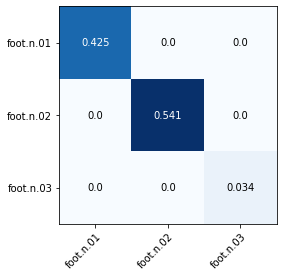

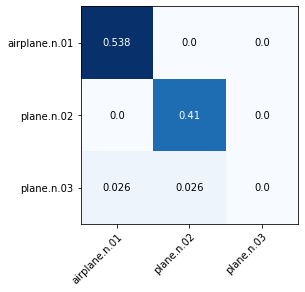

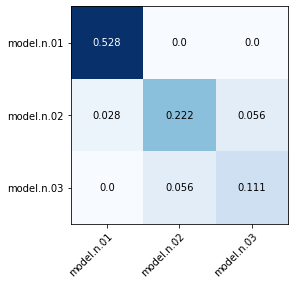

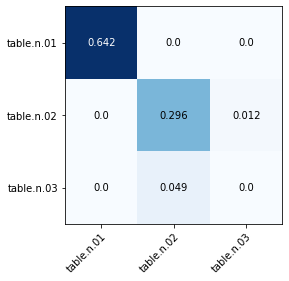

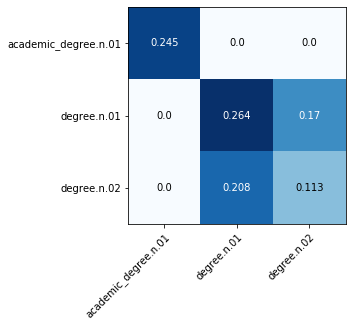

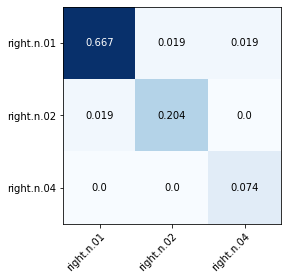

In [135]:
for w in shared_words:
    word_matrices = shared_model_data[w]['confusion_matrices']
    senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))]
    plot_confusion_mtx(word_matrices, senses)

In [97]:
pd.set_option('display.max_colwidth', 500)

pd.concat(incorrect)

,true_label,sentences
0,foot.n.02,"He concluded that the anaconda 's maximum length is 12 or 13 ( perhaps 14 ) meters , which would approximate from 39 to 42 feet ( 14 meters is slightly less that 46 feet ) ."
1,foot.n.02,"Hans Schweizer had one that increased from 19 - 1 2 inches to 5 feet 3 inches in five years , and J . J . Quelch records a growth of from less than 4 feet to nearly 10 in about six years ."
0,plane.n.02,"If a is the major axis of an ellipsoid and b and c are the other two axes , the radius of curvature in the ab plane at the end of the axis is * * f , and the difference in pressure along the a and b axes is * * f ."
1,plane.n.02,"Also , planetary gravitational attraction increases the dust concentration near the plane of the ecliptic as the sun is approached ."
0,model.n.03,`` What kind of models would you prefer '' ?
1,model.n.03,"But at the end of the sitting , when Michelangelo showed him the quick , free drawings , with the mother roughed in , holding her son , the model grasped what Michelangelo was after , and promised to speak to his friends ."
2,model.n.03,He worked for two hours a day with each model sent by the rabbi .
0,table.n.01,It was stated earlier that one purpose of this study was to extend the analysis of variability of Onset and Completion in each of the 21 growth centers somewhat beyond that provided by the data in Tables 1 and 2 .
1,table.n.01,Some of the features of the top portions of Figure 1 and Figure 2 were mentioned in discussing Table 1 .
2,table.n.01,"Although the standard deviation values on which spread of the lines are based are relatively larger for those centers which begin to ossify early ( Table 1 ) , there are considerable differences in this value between centers having the closely timed Onsets ."
